In [1]:
# Part 3 of the Jax tutorial found at:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial3/Activation_Functions.html

In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

<ipython-input-2-46353cc61cc4>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
# Creating some path variables for the dataset and checkpoints of the model
DATASET_PATH = "data"
CHECKPOINT_PATH = "saved_models/tutorial3_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: gpu:0


In [4]:
# This cell downloads all pretrained models that we will use in this notebook

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

Common Activation Functions

In [5]:
# Implementing a bunch of non liniearities

class Sigmoid(nn.Module):
  def __call__(self, x):
    return 1 / (1 + jnp.exp(-x))

class Tanh(nn.Module):
  def __call__(self, x):
    x_exp, neg_x_exp = jnp.exp(x), jnp.exp(-x)
    return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(nn.Module):
  def __call__(self, x):
    return jnp.maximum(x, 0)

class LeakyReLU(nn.Module):
  alpha : float = 0.1

  def __call__(self, x):
    return jnp.where(x > 0, x, self.alpha * x) # return x if x>0 else return alpha*x

class ELU(nn.Module):
  def __call__(self, x):
    return jnp.where(x > 0, x, jnp.exp(x)-1)

class Swish(nn.Module):
  sigmoid : object = Sigmoid()
  def __call__(self, x):
    return x * self.sigmoid(x)

Swish()(-4)

Array(-0.07194484, dtype=float32, weak_type=True)

In [6]:
# Making a dictionary for easy access to activations
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

Visualizing activation functions

In [7]:
# A couple of functions that will plot the activation functions and their gradients.

def get_grads(act_fn, x):
  """
  Computes the gradients of an activation function at specified positions.

  Inputs:
    act_fn - A module or function of the forward pass of the ativation function
    x - 1D input array
  Output:
    An array with the same size of x containing the gradients of act_fn at x.
  """
  return jax.vmap(jax.grad(act_fn))(x)

def vis_act_fn(act_fn, ax, x):
  """
  Plots the activation functions and their gradients
  """
  y = act_fn(x)
  y_grads = get_grads(act_fn, x)

  # Plotting
  ax.plot(x, y, linewidth=2, label="ActFn")
  ax.plot(x, y_grads, linewidth=2, label="Gradient")
  ax.set_title(act_fn.__class__.__name__)
  ax.legend()
  ax.set_ylim(-1.5, x.max())

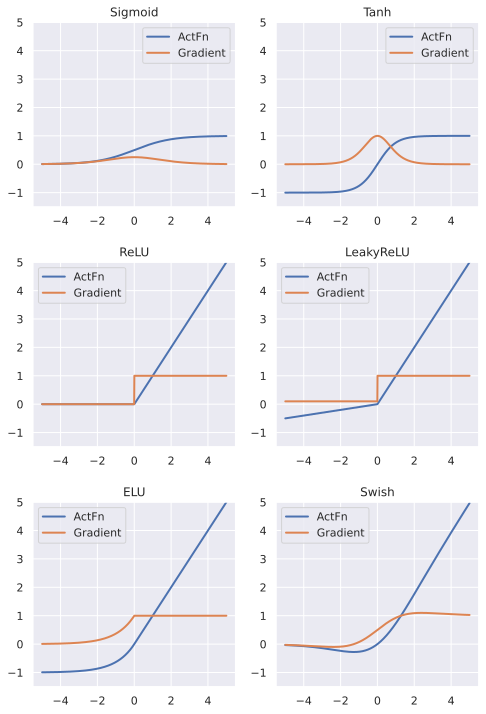

In [8]:
# Plotting the functions
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = np.linspace(-5, 5, 1000)

# plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

Analysing the effect of activation functions

In [9]:
# The initialization of weights may be important depending on the activation being
# used.
init_func = lambda x: (lambda rng, shape, dtype: random.uniform(rng,
                                                                shape=shape,
                                                                minval=-1/np.sqrt(x.shape[1]),
                                                                maxval=1/np.sqrt(x.shape[1]),
                                                                dtype=dtype))

# The actual network
class BaseNetwork(nn.Module):
  act_fn : nn.Module
  num_classes : int = 10
  hidden_sizes : Sequence = (512, 256, 256, 128)

  @nn.compact
  def __call__(self, x, return_activations=False):
    # Reshape image to a flat vector
    x = x.reshape(x.shape[0], -1)

    # collecting  all activations
    activations = []

    # looping through the hidden layers
    for hd in self.hidden_sizes:
      x = nn.Dense(hd,
                   kernel_init=init_func(x), # initializer function for the weight matrix. usually a normal distribution
                   bias_init=init_func(x))(x)
      activations.append(x)
      x = self.act_fn(x)
      activations.append(x)

    x = nn.Dense(self.num_classes,
                 kernel_init=init_func(x),
                 bias_init=init_func(x))(x)

    return x if not return_activations else (x, activations)

In [10]:
# A bunch of functions for loading and saving models

def _get_config_file(model_path, model_name):
  """Name of file for storing hyperparameter details"""
  return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
  """Name of file for storing network parameters"""
  return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, state=None):
  """
  Loads a saved model from disk

  Inputs:
    model_path - path of the checkpoint dir
    model_name - Name of the model (str)
    state - (Optional) If given, the parameters are loaded into this training state.
            Otherwise, a new one is created alongside a network architecture.
  """
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}"
  assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\"."

  # Loading config file
  with open(config_file, "r") as f:
    config_dict = json.load(f)

  if state is None:
    act_fn_name = config_dict["act_fn"].pop("name").lower()
    act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
    net = BaseNetwork(act_fn=act_fn, **config_dict)
    state = train_state.TrainState(step=0,
                                    params=None,
                                    apply_fn=net.apply,
                                    tx=None,
                                    opt_state=None)

  else:
    net = None

  # You can also just use a pickle file!
  with open(model_file, 'rb') as f:
    params = pickle.load(f)
  state = state.replace(params=params)

  return state, net

def save_model(model, params, model_path, model_name):
  """
  Given a model, we save the parameters and hyperparams

  Inputs:
    model - Network object w/o parameters
    params - Parameters to save of the model
    model_path - Path of the checkpoint directory
    model_name - Name of the model (str)
  """
  config_dict = {
      'num_classes': model.num_classes,
      'hidden_sizes': model.hidden_sizes,
      'act_fn': {'name': model.act_fn.__class__.__name__.lower()}
  }

  # if it is a leakyReLU
  if hasattr(model.act_fn, 'alpha'):
    config_dict['act_fn']['alpha'] = model.act_fn.alpha

  os.makedirs(model_path, exist_ok=True)
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  with open(config_file, "w") as f:
    json.dump(config_dict, f)
  # You can also use flax's checkpoint package. To show an alternative,
  # you can instead save the parameters simply in a pickle file.
  with open(model_file, 'wb') as f:
      pickle.dump(params, f)

Data

In [11]:
# `torchvision` is the library we will use to load the data! It seems very useful

import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
      return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
      transposed = zip(*batch)
      return [numpy_collate(samples) for samples in transposed]
  else:
      return np.array(batch)

# Transformations applied on each image => bring them into a numpy array and normalize between -1 and 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.5) / 0.5
    return img

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

100%|██████████| 26421880/26421880 [00:03<00:00, 8278606.87it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140486.35it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2599196.14it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5805936.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



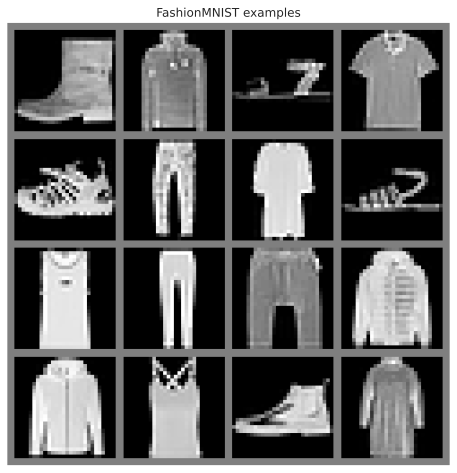

In [12]:
# Data visualization
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.from_numpy(np.stack(exmp_imgs, axis=0))[:,None],
                                       nrow=4,
                                       normalize=True,
                                       pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Visualizing the gradient flow after initialization
* To get a feeling for how activation functions influence gradients

In [13]:
small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, collate_fn=numpy_collate)
exmp_batch = next(iter(small_loader))

In [14]:
def visualize_gradients(net, params, color="C0"):
  """
  Inputs:
    net - Object of the base network
    color - Color in which we want to visualize the histogram (for easier separation of activation functions)
  """
  # Pass one batch through the network and calculate the gradients
  def loss_fn(p):
    imgs, labels = exmp_batch
    logits = net.apply(p, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    return loss

  grads = jax.grad(loss_fn)(params)
  grads = jax.device_get(grads) # A way to get the actual value out of a jax representation
  # Exluding the bias in the plots
  grads = jax.tree_util.tree_leaves(grads)
  grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

  ## Plotting
  columns = len(grads)
  fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
  fig_index = 0
  for g_idx, g in enumerate(grads):
      key = f'Layer {g_idx * 2} - weights'
      key_ax = ax[g_idx%columns]
      sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True) # kde=True is the line above each plot
      key_ax.set_title(str(key))
      key_ax.set_xlabel("Grad magnitude")
  fig.suptitle(f"Gradient magnitude distribution for activation function {net.act_fn.__class__.__name__}", fontsize=14, y=1.05)
  fig.subplots_adjust(wspace=0.45)
  plt.show()
  plt.close()

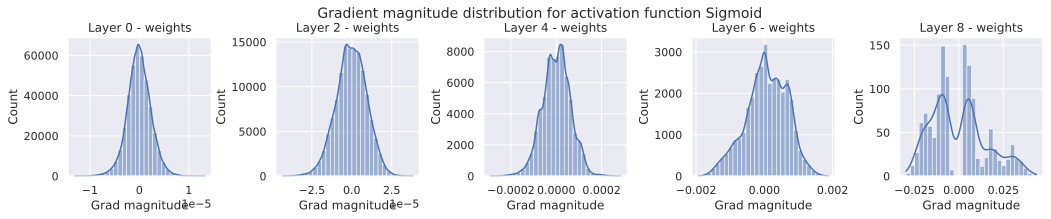

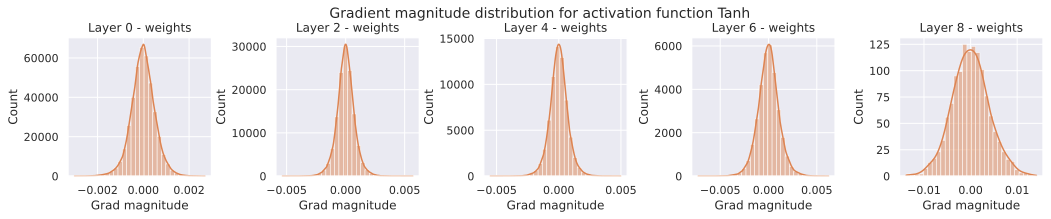

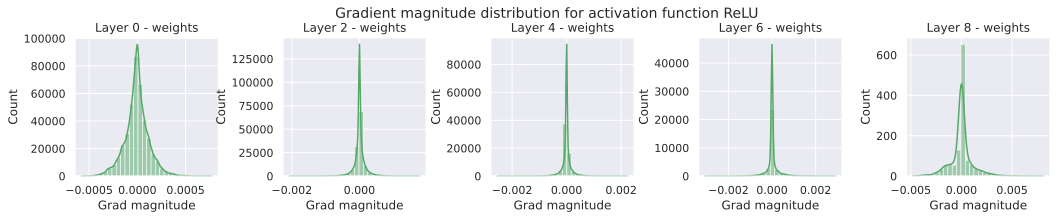

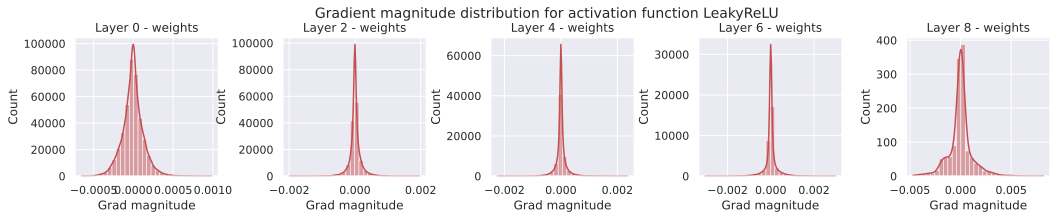

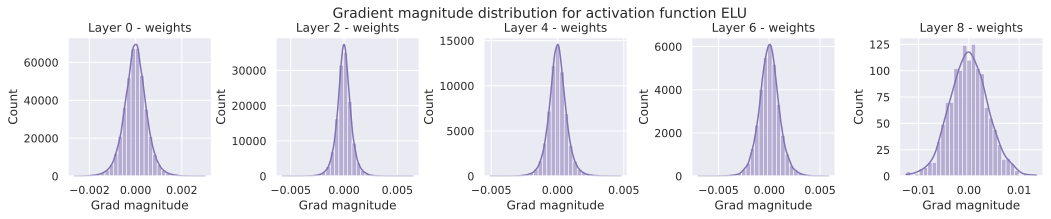

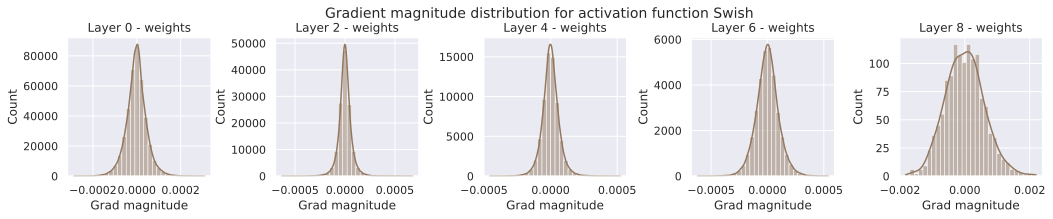

In [15]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name): # Loops through every activation function
    act_fn = act_fn_by_name[act_fn_name]() # gets the activation function out of the dictionary
    net_actfn = BaseNetwork(act_fn=act_fn) # initializing the network with the activation function
    params = net_actfn.init(random.PRNGKey(0), exmp_batch[0]) # Getting the initial parameters of the model
    visualize_gradients(net_actfn, params, color=f"C{i}") # Calling the visualize gradient function to plot

Training the model

In [16]:
# The meat of the model for real for real

def calculate_loss(params, apply_fn, batch):
  imgs, labels = batch
  logits = apply_fn(params, imgs)
  loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
  acc = (labels == logits.argmax(axis=-1)).mean()
  return loss, acc

@jax.jit
def train_step(state, batch):
  grad_fn = jax.value_and_grad(calculate_loss,
                               has_aux=True)
  (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
  state = state.apply_gradients(grads=grads)
  return state, acc

@jax.jit # You should jit the evaluation function even though it's not taking gradients
def eval_step(state, batch):
  _, acc = calculate_loss(state.params, state.apply_fn, batch)
  return acc

In [17]:
# Training loop and validation for a bunch of epochs and also a test set
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
  """
  Train a model on the training set of FashionMNIST

  Inputs:
    net - Object of BaseNetwork
    model_name - (str) Name of the model, used for creating the checkpoint names
    max_epochs - Number of epochs we want to (maximally) train for
    patience - If the performance on the validation set has not improved for #patience epochs,
               we stop training early
    batch_size - Size of batches used in training
    overwrite - Determines how to handle the case when there already exists a checkpoint.
                If True, it will be overwritten. Otherwise, we skip training.
  """
  file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
  if file_exists and not overwrite:
    print("Model file already exists. Skipping training...")
    state = None
  else:
    if file_exists:
      print("Model file exists, but will be overwritten...")

    # Initializing parameters and training state
    params = net.init(random.PRNGKey(42), exmp_batch[0])
    state = train_state.TrainState.create(apply_fn=net.apply,
                                          params=params,
                                          tx=optax.sgd(learning_rate=1e-2,
                                                       momentum=0.9))

    # Defining the data loader
    train_loader_local = data.DataLoader(train_set,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True,
                                         collate_fn=numpy_collate,
                                         generator=torch.Generator().manual_seed(42))

    # Big loop for training and validation
    val_scores = []
    best_val_epoch = -1
    for epoch in range(max_epochs):

      ############
      # Training #
      ############
      train_acc = 0.
      for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
        state, acc = train_step(state, batch)
        train_acc += acc
      train_acc /= len(train_loader_local)

      ##############
      # Validation #
      ##############
      val_acc = test_model(state, val_loader)
      val_scores.append(val_acc)
      print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

      if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
        print("\t (New best performance, saving model...)")
        save_model(net, state.params, CHECKPOINT_PATH, model_name)
        best_val_epoch = epoch
      elif best_val_epoch <= epoch - patience:
        print(f"Early stopping due to no improvement over last {patience} epochs.")
        break

    # Plot a curve of the validation accuracy
    plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title(f"Validation performance of {model_name}")
    plt.show()
    plt.close()

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    test_acc = test_model(state, test_loader)
    print((f" Test accuracy: {test_acc:4.2%} ").center(50, "=")+"\n")
    return state, test_acc

def test_model(state, data_loader):
  """
  Test a model on a specified dataset

  INPUTS:
    state - Training state including parameters and model apply function
    data_loader - Dataloader object of the dataset to test on (validation or test)
  """
  true_preds, count = 0., 0.
  for batch in data_loader:
    acc = eval_step(state, batch)
    batch_size = batch[0].shape[0]
    true_preds += acc * batch_size
    count += batch_size

  test_acc = true_preds / count

  return test_acc

In [18]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
Training BaseNetwork with swish activation...
Model file already exists. Skipping training...


Visualizing the activation distribution

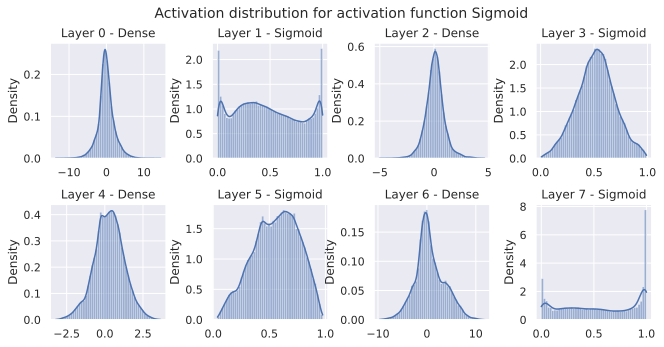

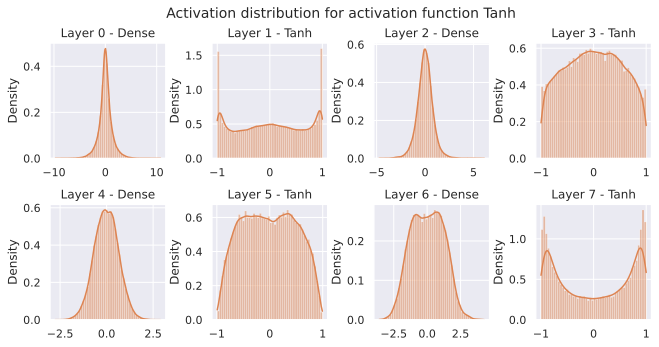

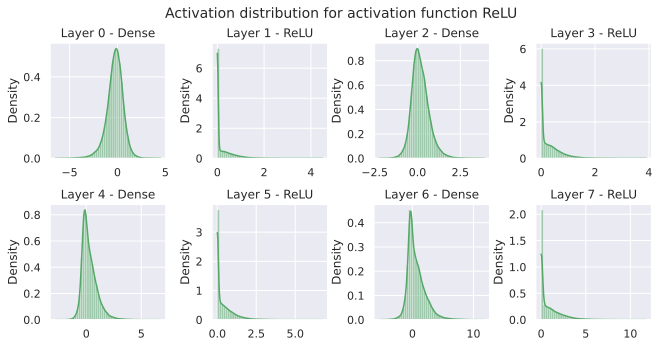

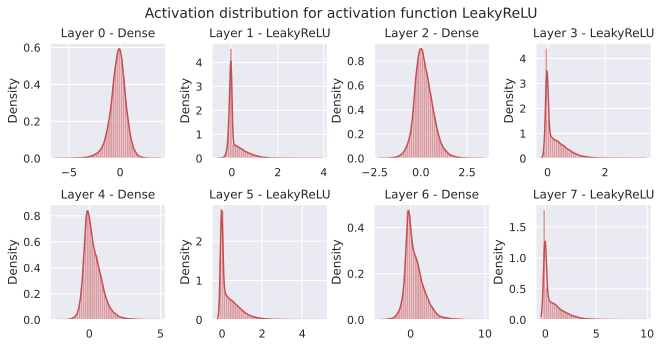

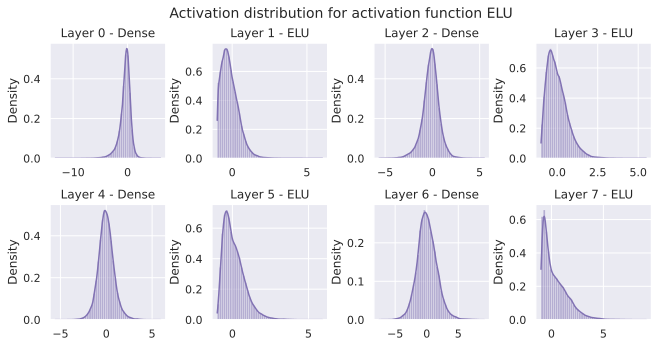

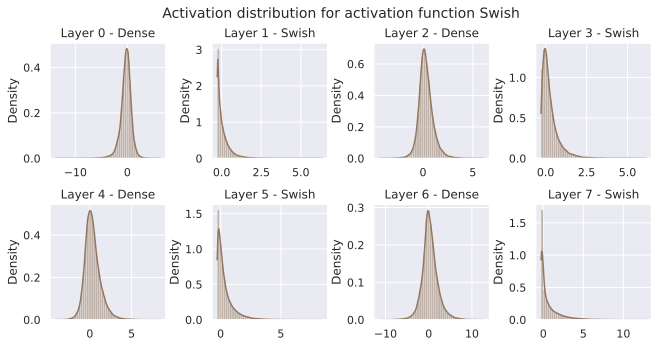

In [20]:
# Function for looking at the values within the model

def visualize_activations(net, color="C0"):
  activations = {}

  imgs, labels = exmp_batch
  _, activations = net(imgs, return_activations=True) # This is how you can return activations because of how the BaseNetwork is set up
                                                      # `activations` is a length 8 list of activations
                                                      # There are 8 layers because one fully connected layer and then pass through the activation function
                                                      # for each of the `hidden_sizes` in the model.
                                                      # The shape of each is the batch size by how many nodes in the layer

  ## Plotting
  columns = 4
  rows = math.ceil(len(activations)/columns)
  fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
  act_fn_name = net.act_fn.__class__.__name__
  for idx, activ in enumerate(activations):
      key_ax = ax[idx//columns][idx%columns]
      sns.histplot(data=activ.reshape(-1), bins=50, ax=key_ax, color=color, kde=True, stat="density")
      key_ax.set_title(f"Layer {idx} - {'Dense' if idx%2==0 else act_fn_name}")
  fig.suptitle(f"Activation distribution for activation function {act_fn_name}", fontsize=14)
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  plt.show()
  plt.close()

for i, act_fn_name in enumerate(act_fn_by_name):
  state, net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}")
  net_actfn = net_actfn.bind(state.params)
  visualize_activations(net_actfn, color=f"C{i}")

Finding dead neurons in ReLU networks
* Dead neurons are neurons that are 0 for every datapoint.
* This is because every value before the ReLU layers are negative and thus the gradient is 0


In [21]:
def measure_number_dead_neurons(net, params):
  """
  For each neuron, we create a boolean variable initially set to 1. If it has an
  activation that is not equal to 0 at any time we set this variable to 0. After
  running through the whole training set, only dead neurons will have a 1.
  """
  neurons_dead = [
      jnp.ones(hd, dtype=jnp.dtype('bool')) for hd in net.hidden_sizes
  ]
  get_activations = jax.jit(lambda inp: net.apply(params, inp, return_activations=True)[1])
  for imgs, _ in tqdm(train_loader, leave=False):
    activations = get_activations(imgs)
    for layer_index, activ in enumerate(activations[1::2]):
      # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
      neurons_dead[layer_index] = jnp.logical_and(neurons_dead[layer_index], (activ == 0).all(axis=0))

  number_neurons_dead = [t.sum().item() for t in neurons_dead]
  print("Number of dead neurons:", number_neurons_dead)
  print("In percentage:", ", ".join([f"{num_dead / tens.shape[0]:4.2%}" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [22]:
# Number of dead neurons for an untrained network
net_relu = BaseNetwork(act_fn=ReLU())
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 7]
In percentage: 0.00%, 0.00%, 1.17%, 5.47%


In [23]:
# Trained network
state, net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu")
measure_number_dead_neurons(net_relu, state.params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 3]
In percentage: 0.00%, 0.00%, 1.17%, 2.34%


In [26]:
# Checking the number of nead neurons with increasing network depth
net_relu = BaseNetwork(act_fn=ELU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%, 0.00%
